In [3]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import segmentation_models as sm
import matplotlib
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [4]:
tf.__version__

'2.1.0'

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12477926753409446031
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2150326929920637052
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14130574259440581385
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11338085172
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12251587566037108033
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


# Data preparation

In [6]:
images = list(Path(os.path.join('../data/unet/lung_segmentation/CXR_png/img')).glob('**/*'))
masks = list(Path(os.path.join('../data/unet/lung_segmentation/masks/img')).glob('**/*'))

In [7]:
print("Amount of images: ", len(images))
print("Amount of masks: ", len(masks))

Amount of images:  800
Amount of masks:  704


In [8]:
img_mask_tuples = []

for mask_path in masks:
    for i in images:
        basename = (os.path.basename(i)).split(".")[0]
        if basename in str(mask_path):
            img_path = i
            break
    img_mask_tuples.append((str(img_path), str(mask_path)))

In [9]:
len(img_mask_tuples)

704

## Plot images and masks

In [10]:
def plot_img(img_mask_tuple):
    img_concat = np.concatenate((cv2.imread(str(img_mask_tuple[0])), cv2.imread(str(img_mask_tuple[1]))), axis=1)
    plt.axis('off')
    plt.imshow(img_concat)

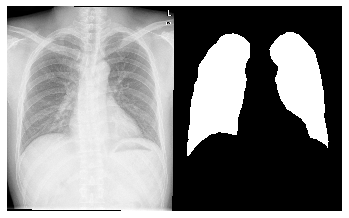

In [11]:
plot_img(img_mask_tuples[1])

In [12]:
def plot_img_matrix(img_mask_tuple_list, cols):
    # concat
    images = []
    for t in img_mask_tuple_list:
        img_concat = np.concatenate((cv2.imread(str(t[0])), cv2.imread(str(t[1]))), axis=1)
        images.append(img_concat)
    # plot
    plt.subplots(figsize=(15,5))
    if len(images) % cols == 0:
        rows = len(images) / cols
    else:
        rows = (len(images) % cols) +1
    for num, x in enumerate(images):
        plt.subplot(rows,cols,num+1)
        plt.axis('off')
        plt.imshow(x)

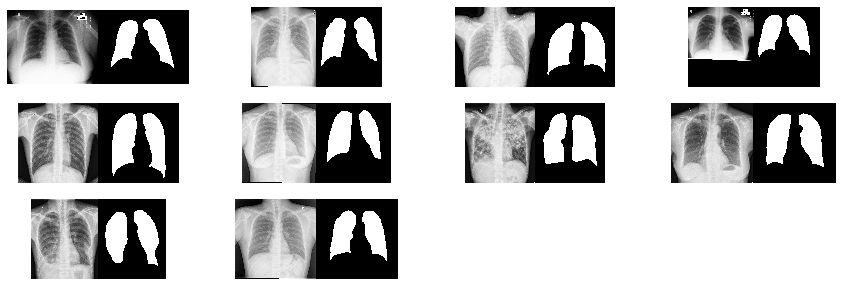

In [13]:
plot_img_matrix(img_mask_tuples[:10], 4)

## Train-Validation split

In [14]:
df = pd.DataFrame(img_mask_tuples, dtype='str', columns=['img', 'mask'])
train = df.sample(frac=0.8, random_state=200)
test = df.drop(train.index)

In [15]:
test.head()

,img,mask
0,../data/unet/lung_segmentation/CXR_png/img/MCU...,../data/unet/lung_segmentation/masks/img/MCUCX...
2,../data/unet/lung_segmentation/CXR_png/img/CHN...,../data/unet/lung_segmentation/masks/img/CHNCX...
6,../data/unet/lung_segmentation/CXR_png/img/CHN...,../data/unet/lung_segmentation/masks/img/CHNCX...
7,../data/unet/lung_segmentation/CXR_png/img/CHN...,../data/unet/lung_segmentation/masks/img/CHNCX...
17,../data/unet/lung_segmentation/CXR_png/img/CHN...,../data/unet/lung_segmentation/masks/img/CHNCX...


## UNET

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

img_generator = train_datagen.flow_from_dataframe(
    dataframe= pd.DataFrame(train['img']), # images
    directory=None,
    x_col="img",
    target_size=(256, 256),
    class_mode=None,
    batch_size=32
)
mask_generator = train_datagen.flow_from_dataframe(
    dataframe= pd.DataFrame(train['mask']), # masks
    directory=None,
    x_col="mask",
    target_size=(256, 256),
    class_mode=None,
    batch_size=32
)

val_img_generator = val_datagen.flow_from_dataframe(
    dataframe= pd.DataFrame(test['img']), # images
    directory=None,
    x_col="img",
    target_size=(256, 256),
    class_mode=None,
    batch_size=32
)
val_mask_generator = val_datagen.flow_from_dataframe(
    dataframe= pd.DataFrame(test['mask']), # masks
    directory=None,
    x_col="mask",
    target_size=(256, 256),
    class_mode=None,
    batch_size=32
)

# https://github.com/keras-team/keras/issues/13123#issuecomment-529498919
train_generator = (pair for pair in zip(img_generator, mask_generator))
val_generator = (pair for pair in zip(val_img_generator, val_mask_generator))

Found 563 validated image filenames.
Found 563 validated image filenames.
Found 141 validated image filenames.
Found 141 validated image filenames.


In [17]:
model = sm.Unet()
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)
# model.summary()

58892288/58889256 [==============================] - 1s 0us/step


In [19]:
# AWS needs keras.callbacks not tensorflow.keras.callbacks --> https://github.com/keras-team/keras/issues/13258
mcp_save = ModelCheckpoint('../models/unet_aws_2208.h5', save_best_only=True, monitor='iou_score', mode='max')

In [20]:
history = model.fit(train_generator, 
                    validation_data=val_generator,
                    steps_per_epoch=200, 
                    validation_steps=200,
                    epochs=5,
                    callbacks=[mcp_save])

Epoch 1/5
200/200 [==============================] - 2020s 10s/step - loss: 0.7147 - iou_score: 0.5697 - val_loss: 0.7790 - val_iou_score: 0.6329
Epoch 2/5
200/200 [==============================] - 1926s 10s/step - loss: 0.6598 - iou_score: 0.6034 - val_loss: 0.7790 - val_iou_score: 0.5996
Epoch 3/5
200/200 [==============================] - 1917s 10s/step - loss: 0.6571 - iou_score: 0.6051 - val_loss: 1.2506 - val_iou_score: 0.4075
Epoch 4/5
200/200 [==============================] - 1916s 10s/step - loss: 0.6604 - iou_score: 0.6031 - val_loss: 2.1175 - val_iou_score: 0.0395
Epoch 5/5
200/200 [==============================] - 1917s 10s/step - loss: 0.6564 - iou_score: 0.6051 - val_loss: 0.9442 - val_iou_score: 0.5078


In [18]:
# model.save('../models/unet_aws_2208.h5')

In [21]:
# Loading
# model = keras.models.load_model('../models/unet_0908.h5', custom_objects={'loss': sm.losses.bce_jaccard_loss})
# model = keras.models.load_model('../models/unet_0908.h5', compile=False)

##  Pred masks for chest-x-ray dataset

In [21]:
chestx_train_normal_images = list(Path(os.path.join('../data/chest-x-ray/train/NORMAL')).glob('**/*'))
chestx_train_pneunomia_images = list(Path(os.path.join('../data/chest-x-ray/train/PNEUMONIA')).glob('**/*'))

chestx_train_normal_images_df = pd.DataFrame(chestx_train_normal_images, dtype='str', columns=['img'])
chestx_train_pneunomia_images_df = pd.DataFrame(chestx_train_pneunomia_images, dtype='str', columns=['img'])

In [22]:
pred_normal_generator = train_datagen.flow_from_dataframe(
    dataframe=chestx_train_normal_images_df,
    x_col='img',
    directory=None,
    target_size=(256, 256),
    class_mode=None,
    batch_size=32
)

pred_penumonia_generator = train_datagen.flow_from_dataframe(
    dataframe=chestx_train_pneunomia_images_df,
    x_col='img',
    directory=None,
    target_size=(256, 256),
    class_mode=None,
    batch_size=32
)

Found 1341 validated image filenames.
Found 3875 validated image filenames.


In [23]:
chestx_normal_pred_masks = model.predict(pred_normal_generator)
chestx_penumonia_pred_masks = model.predict(pred_penumonia_generator)

In [24]:
def save_pred_masks(df, pred_masks, path):
    for i in range(0,len(pred_masks)):
        org_img = df.iloc[i][0]
        pred_mask_name = os.path.basename(org_img).split('.')[0] + '_predmask.jpg'
        plt.imsave(path + pred_mask_name, pred_masks[i][:,:,0], cmap='gray')

In [26]:
save_pred_masks(chestx_train_normal_images_df, chestx_normal_pred_masks, '../data/chest-x-ray/masks/train/NORMAL/')

In [27]:
save_pred_masks(chestx_train_pneunomia_images_df, chestx_penumonia_pred_masks, '../data/chest-x-ray/masks/train/PNEUMONIA/')

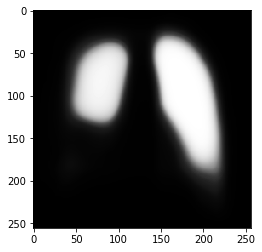

In [33]:
plt.imshow(chestx_normal_pred_masks[50][:,:,0], cmap='gray')

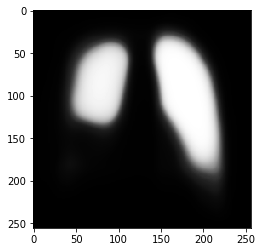

In [36]:
plt.imshow(chestx_penumonia_pred_masks[100][:,:,0], cmap='gray')